## Notebook to train PLSR model for CE prediction using graph embeddings (LUMO-pretrained model)

### Graph embeddings size = 200

**Split: stratified split-2 + stratified CV**

**Output units: common log**

**Created on 16th December, 2023; modified on 17th January, 2024**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
from matplotlib import colors as mcolors
import matplotlib
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import os
import sys
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, r2_score, mean_squared_error, mean_absolute_error
import glob
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, cross_val_score, RandomizedSearchCV
import pickle

In [2]:
%%bash
pwd
ls -ltr

/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/Science-rev-1/coulombic-efficiency_1.1/using-pretrainedGR/gr-embed-200/common-log-output/stratified-split-2-cv
total 8512
-rw-r--r--    1 riteshk  staff  907086 Jan 17 14:41 train_gr_comb_add.csv
-rw-r--r--    1 riteshk  staff  126776 Jan 17 14:41 test_gr_comb_add.csv
-rw-r--r--    1 riteshk  staff  118767 Jan 17 14:41 val_gr_comb_add.csv
-rw-r--r--    1 riteshk  staff  261305 Jan 17 14:49 ood_gr_comb_add.csv
-rw-r--r--    1 riteshk  staff  126776 Jan 17 15:36 strat_rs0_test_gr_comb_add.csv
-rw-r--r--@   1 riteshk  staff  907575 Jan 17 15:36 strat_rs0_train_gr_comb_add.csv
-rw-r--r--    1 riteshk  staff  118592 Jan 17 15:36 strat_rs0_val_gr_comb_add.csv
-rw-r--r--    1 riteshk  staff  126589 Jan 17 15:36 strat_rs17_test_gr_comb_add.csv
-rw-r--r--    1 riteshk  staff  907607 Jan 17 15:36 strat_rs17_train_gr_comb_add.csv
-rw-r--r--    1 riteshk  staff  118747 Jan 17 15:36 strat_rs17_val_gr_comb_add.csv
-rw

In [13]:
def plot_parity(y_true, y_pred, y_pred_unc=None, figname=None):
    plt.clf()
    
    axmin = min(min(y_true), min(y_pred)) - 0.1*(max(y_true)-min(y_true))
    axmax = max(max(y_true), max(y_pred)) + 0.1*(max(y_true)-min(y_true))
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    
    plt.plot([axmin, axmax], [axmin, axmax], '--k')
    
    plt.errorbar(y_true, y_pred, yerr=y_pred_unc, linewidth=0, marker='o', markeredgecolor='w', alpha=1, elinewidth=1, color='blue', markersize=8)
    
    plt.xlim((axmin, axmax))
    plt.ylim((axmin, axmax))
    
    ax = plt.gca()
    ax.set_aspect('equal')
    
    at = AnchoredText(
    f"MAE = {mae:.2f}\nRMSE = {rmse:.2f}\nR$^2$ = {r2:.2f}", prop=dict(size=10), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    
    plt.xlabel('True log$_{10}{}$CI')
    plt.ylabel('ML-predicted log$_{10}{}$CI')
    if figname != None:
        plt.savefig(figname, dpi=150)
    else:
        plt.show()
        
    ax.clear()
    return

In [3]:
df_train = pd.read_csv('./strat_rs30_train_gr_comb_add.csv')
df_val = pd.read_csv('./strat_rs30_val_gr_comb_add.csv')
df_test = pd.read_csv('./strat_rs30_test_gr_comb_add.csv')
df_ood = pd.read_csv('./ce_ood_final_comp.csv')

**New stratified split with seed = 30: on 4th February, 2024**

In [5]:
df_all = pd.concat([df_train, df_val, df_test], axis=0, ignore_index=True)
df_all

,solv_smile_comb,salt_smile_comb,solv_fp_0_mol_0,solv_fp_1_mol_0,solv_fp_2_mol_0,solv_fp_3_mol_0,solv_fp_4_mol_0,solv_fp_5_mol_0,solv_fp_6_mol_0,solv_fp_7_mol_0,...,solv_ratio_3,mw_salt_1,mw_salt_2,salt_1_conc,salt_2_conc,mw_add,protocol,current_density,log(1-CE),CE_binned
0,C1COCO1.COCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+].O=S(=O)([N-]S(=...,-0.006039,-0.004283,-0.013746,-0.005626,-0.005084,-0.004713,-0.006876,0.033564,...,0.0,186.939685,286.933298,0.5,0.5,0.000000,3,0.25,-2.000000,2
1,COCCOCCOCCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+].O=C1OCCO1,-0.005236,0.010172,-0.012011,-0.008903,-0.006002,-0.005831,-0.007050,0.042227,...,0.0,186.939685,0.000000,3.0,0.0,88.016044,1,0.40,-1.443697,3
2,O=C1OCCO1.CCOC(=O)OCC,[Li+].[O-][Cl+3]([O-])([O-])[O-],0.069424,0.046331,-0.015139,0.083333,-0.011125,-0.007302,-0.011989,-0.007036,...,0.0,105.964516,0.000000,1.0,0.0,0.000000,1,1.00,-0.856985,5
3,O=C1OCC(F)O1.COCCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],0.137776,0.012570,-0.012399,0.089359,-0.008272,-0.005663,0.001472,0.037405,...,0.0,186.939685,0.000000,1.0,0.0,0.000000,4,1.00,-0.918653,4
4,CCCCOCCCC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.006658,0.133333,-0.013576,-0.009701,0.071500,-0.006591,-0.007900,0.008567,...,0.0,186.939685,0.000000,2.0,0.0,0.000000,4,0.50,-2.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,C1COCO1.COCCOC,O=S(=O)([N-]S(=O)(=O)C(F)(F)F)C(F)(F)F.[Li+].O...,-0.005876,-0.003536,-0.013445,-0.006262,-0.005175,-0.005150,-0.007151,0.047249,...,0.0,286.933298,0.000000,1.0,0.0,69.003822,0,0.50,-2.000000,2
138,O=C1OCCO1.COC(=O)OC,F[P-](F)(F)(F)(F)F.[Li+].O=C1OCC(F)O1,0.070854,0.054446,-0.014466,0.087637,-0.011126,-0.007172,-0.011968,-0.006509,...,0.0,151.980186,0.000000,1.0,0.0,106.006622,2,1.00,-1.318759,3
139,O=C1OCCO1.CCOC(=O)OC,F[P-](F)(F)(F)(F)F.[Li+],0.064821,0.049995,-0.014755,0.082037,-0.011125,-0.007197,-0.012041,-0.006816,...,0.0,151.980186,0.000000,1.0,0.0,0.000000,1,0.50,-0.742321,5
140,COCCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.005390,-0.004935,-0.011686,-0.010327,-0.004394,-0.005828,-0.007275,0.091065,...,0.0,186.939685,0.000000,4.0,0.0,0.000000,1,0.20,-2.045757,2


In [6]:
print(df_all['log(1-CE)'].max())
print(df_all['log(1-CE)'].min())

-0.0409586074742489
-3.221848749725743


In [5]:
seed = 30
df_rest, df_test, y_rest, y_test = train_test_split(df_all, df_all['CE_binned'], test_size=0.1, random_state=seed, stratify=df_all['CE_binned'])
req_len = len(df_test)
rat = req_len/len(df_rest)
df_train, df_val, y_train, y_val = train_test_split(df_rest, df_rest['CE_binned'], test_size=rat, random_state=seed, stratify=df_rest['CE_binned'])
df_train.to_csv('./strat_rs30_train_gr_comb_add.csv', index=False)
df_val.to_csv('./strat_rs30_val_gr_comb_add.csv', index=False)
df_test.to_csv('./strat_rs30_test_gr_comb_add.csv', index=False)

X_train = df_train.iloc[:, 2:-2]  # Assuming first two columns are descriptions
y_train = df_train.iloc[:, -2].values
X_val = df_val.iloc[:, 2:-2]
y_val = df_val.iloc[:, -2].values
X_test = df_test.iloc[:, 2:-2]
y_test = df_test.iloc[:, -2].values
X_ood = df_ood.iloc[:, 2:-1]
y_ood = df_ood.iloc[:, -1].values

## scaling the data
scaler = MinMaxScaler().fit(X_train.iloc[:,-13:])
X_train_scaled = scaler.transform(X_train.iloc[:,-13:])
X_train_ = np.concatenate((X_train.iloc[:,:-13], X_train_scaled), axis=1)
X_val_scaled = scaler.transform(X_val.iloc[:,-13:])
X_val_ = np.concatenate((X_val.iloc[:,:-13], X_val_scaled), axis=1)
X_test_scaled = scaler.transform(X_test.iloc[:,-13:])
X_test_ = np.concatenate((X_test.iloc[:,:-13], X_test_scaled), axis=1)
X_ood_scaled = scaler.transform(X_ood.iloc[:,-13:])
X_ood_ = np.concatenate((X_ood.iloc[:,:-13], X_ood_scaled), axis=1)

## run only once!!
r2_train_fin = []; rmse_train_fin = []; mae_train_fin = []
r2_val_fin = []; rmse_val_fin = []; mae_val_fin = []
r2_test_fin = []; rmse_test_fin = []; mae_test_fin = []
r2_ood_fin = []; rmse_ood_fin = []; mae_ood_fin = []
comp_fin = []

# for comp in range(5, 13):
    # print(f"*********Number of components: {comp}***********")
    # ncomp = comp
ncomp = 11

## optimize over random states of KFold
rmse_cv_array = []
for i in range(0,100):
    # print(f"Step {i}")
    # Initialize KFold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
    stratify_labels = df_train['CE_binned']
    plsr = PLSRegression(n_components=ncomp, scale=False)
    # plsr = PLSRegression(n_components=ncomp, scale=True) ## don't use scale=True

    fold = 1
    # Loop over each fold
    rmse_val = []; rmse_train = []
    for train_index, val_index in skf.split(X_train_, stratify_labels):
        # print("Fold {}".format(fold))
        # Split the data
        X_train_fold, X_val_fold = X_train_[train_index], X_train_[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Fit the model on the training data
        plsr.fit(X_train_fold, y_train_fold)

        y_pred_val_fold = plsr.predict(X_val_fold)
        r2 = r2_score(y_val_fold, y_pred_val_fold); rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_val_fold)); mae = mean_absolute_error(y_val_fold, y_pred_val_fold)
        # print(f"Train set CV, R2 score: {r2}, RMSE: {rmse}, MAE: {mae}")
        rmse_train.append(rmse)

        ## predict on validation test
        y_pred_val = plsr.predict(X_val_)
        r2 = r2_score(y_val, y_pred_val); rmse = np.sqrt(mean_squared_error(y_val, y_pred_val)); mae = mean_absolute_error(y_val, y_pred_val)
        # print(f"Validation set, R2 score: {r2}, RMSE: {rmse}, MAE: {mae}")
        rmse_val.append(rmse)

        fold += 1
    # print(f"RMSE train: {np.mean(rmse_train)} & RMSE val: {np.mean(rmse_val)}")
    rmse_cv_array.append(np.mean(rmse_train))

ind = min(range(len(rmse_cv_array)), key=rmse_cv_array.__getitem__)
print(rmse_cv_array[ind])

## use the best random state to train the model
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=ind)
stratify_labels = df_train['CE_binned']

plsr = PLSRegression(n_components=ncomp, scale=False)

fold = 1
# Loop over each fold
pred_train_array = []; pred_val_array = []; pred_test_array = []
for train_index, val_index in skf.split(X_train_, stratify_labels):
    X_train_fold, X_val_fold = X_train_[train_index], X_train_[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Fit the model on the training data
    plsr.fit(X_train_fold, y_train_fold)

    # Store the model
    # models.append(plsr)
    y_pred_val_fold = plsr.predict(X_val_fold)
    r2 = r2_score(y_val_fold, y_pred_val_fold); rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_val_fold)); mae = mean_absolute_error(y_val_fold, y_pred_val_fold)
    
    y_pred_train = plsr.predict(X_train_)
    pred_train_array.append(y_pred_train)

    ## predict on validation test
    y_pred_val = plsr.predict(X_val_)
    pred_val_array.append(y_pred_val)

    # ## predict on test set
    y_pred_test = plsr.predict(X_test_)
    pred_test_array.append(y_pred_test)

    ## save plsr model to pickle
    filename = f'./plsr_model_strat_ncomp_{ncomp}_fold_{fold}.sav'
    pickle.dump(plsr, open(filename, 'wb'))
    fold += 1

## calculate the average of the predictions on train, val and test
y_pred_train_avg = np.mean(pred_train_array, axis=0); y_pred_val_avg = np.mean(pred_val_array, axis=0); y_pred_test_avg = np.mean(pred_test_array, axis=0)
r2_train = r2_score(y_train, y_pred_train_avg); rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train_avg)); mae_train = mean_absolute_error(y_train, y_pred_train_avg)
r2_val = r2_score(y_val, y_pred_val_avg); rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val_avg)); mae_val = mean_absolute_error(y_val, y_pred_val_avg)
r2_test = r2_score(y_test, y_pred_test_avg); rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test_avg)); mae_test = mean_absolute_error(y_test, y_pred_test_avg)
print(f"RMSE train: {rmse_train} & RMSE val: {rmse_val} & RMSE test: {rmse_test}")
print(f"R2 train: {r2_train} & R2 val: {r2_val} & R2 test: {r2_test}")
print(f"MAE train: {mae_train} & MAE val: {mae_val} & MAE test: {mae_test}")

## predict on ood & save parity plot
pred_array = []
# r2_ood = []; rmse_ood = []; mae_ood = []
for i in range(1,6):
    filename = f'./plsr_model_strat_ncomp_{ncomp}_fold_{i}.sav'
    loaded_model = pickle.load(open(filename, 'rb'))
    y_pred_ood = loaded_model.predict(X_ood_)
    pred_array.append(y_pred_ood)
    # r2 = r2_score(y_ood_, y_pred_ood); rmse = np.sqrt(mean_squared_error(y_ood_red, y_pred_ood)); mae = mean_absolute_error(y_ood_red, y_pred_ood)
    # r2_ood.append(r2); rmse_ood.append(rmse); mae_ood.append(mae)
    # print(f"Fold {i}, R2 score: {r2}, RMSE: {rmse}, MAE: {mae}")

# y_l = x_l = np.linspace(-6, -0.5, 100)
y_pred_ood_avg = np.mean(pred_array, axis=0)
y_pred_ood_avg = np.ravel(y_pred_ood_avg)
y_pred_ood_std = np.std(pred_array, axis=0)
y_pred_ood_std = np.ravel(y_pred_ood_std)
rmse_ood = np.sqrt(mean_squared_error(y_ood, y_pred_ood_avg)); mae_ood = mean_absolute_error(y_ood, y_pred_ood_avg); r2_ood = r2_score(y_ood, y_pred_ood_avg)
print(f"Avg RMSE ood: {rmse_ood}, Avg MAE ood: {mae_ood}, Avg R2 ood: {r2_ood}")
## do not use this plot
# y_pred_ood = pred_array[2]
# plt.plot(y_ood_red, y_pred_ood, 'o')
# plt.errorbar(y_ood, y_pred_ood_avg, yerr=y_pred_ood_std, fmt='o')
# # plt.plot(y_ood_red, y_pred_ood_avg, 'o')
# plt.xlabel('True Values')
# plt.ylabel('Predictions')
# plt.axis('equal')
# plt.plot(y_l, x_l, '--')
# plt.savefig('./check_seed/seed{}_plsr_stratified_ood_comp{}.png'.format(seed, ncomp), dpi=150)
## use this one instead
# plot_parity(y_ood, y_pred_ood_avg, y_pred_ood_std, figname='./seed{}_plsr_stratified_ood_comp{}.png'.format(seed, ncomp))

r2_train_fin.append(r2_train); rmse_train_fin.append(rmse_train); mae_train_fin.append(mae_train)
r2_val_fin.append(r2_val); rmse_val_fin.append(rmse_val); mae_val_fin.append(mae_val)
r2_test_fin.append(r2_test); rmse_test_fin.append(rmse_test); mae_test_fin.append(mae_test)
r2_ood_fin.append(r2_ood); rmse_ood_fin.append(rmse_ood); mae_ood_fin.append(mae_ood)
# comp_fin.append(ncomp)

score_df = pd.DataFrame({'Seed': seed, 'Components': ncomp, 'R2_train': r2_train_fin, 'RMSE_train': rmse_train_fin, 'MAE_train': mae_train_fin, 'R2_val': r2_val_fin, 'RMSE_val': rmse_val_fin, 'MAE_val': mae_val_fin, 'R2_test': r2_test_fin, 'RMSE_test': rmse_test_fin, 'MAE_test': mae_test_fin, 'R2_ood': r2_ood_fin, 'RMSE_ood': rmse_ood_fin, 'MAE_ood': mae_ood_fin})
score_df.to_csv('./seed_{}_plsr_cv_scores_strat.csv'.format(seed), index=False)
# seed_perf_df = pd.concat([seed_perf_df, score_df], axis=0, ignore_index=True)

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/model_se

0.5029294754305935
RMSE train: 0.3017095165970308 & RMSE val: 0.38394536159884446 & RMSE test: 0.4110886311472843
R2 train: 0.7277064001945004 & R2 val: 0.48043911454335053 & R2 test: 0.5568982376847902
MAE train: 0.21485294651157702 & MAE val: 0.3205916598250504 & MAE test: 0.30336821458722707
Avg RMSE ood: 0.37654133322850153, Avg MAE ood: 0.2844631842190987, Avg R2 ood: 0.1705488902816642


**Hexabin parity plot for manuscript (Fig 2f)**

In [4]:
X_train = df_train.iloc[:, 2:-2]  # Assuming first two columns are descriptions
y_train = df_train.iloc[:, -2].values
X_val = df_val.iloc[:, 2:-2]
y_val = df_val.iloc[:, -2].values
X_test = df_test.iloc[:, 2:-2]
y_test = df_test.iloc[:, -2].values
X_ood = df_ood.iloc[:, 2:-1]
y_ood = df_ood.iloc[:, -1].values

## scaling the data
scaler = MinMaxScaler().fit(X_train.iloc[:,-13:])
X_train_scaled = scaler.transform(X_train.iloc[:,-13:])
X_train_ = np.concatenate((X_train.iloc[:,:-13], X_train_scaled), axis=1)
X_val_scaled = scaler.transform(X_val.iloc[:,-13:])
X_val_ = np.concatenate((X_val.iloc[:,:-13], X_val_scaled), axis=1)
X_test_scaled = scaler.transform(X_test.iloc[:,-13:])
X_test_ = np.concatenate((X_test.iloc[:,:-13], X_test_scaled), axis=1)
X_ood_scaled = scaler.transform(X_ood.iloc[:,-13:])
X_ood_ = np.concatenate((X_ood.iloc[:,:-13], X_ood_scaled), axis=1)

In [7]:
pred_train_array = []; pred_val_array = []; pred_test_array = []; pred_array = []
for i in range(1,6):
    filename = f'plsr_model_strat_ncomp_11_fold_{i}.sav'
    loaded_model = pickle.load(open(filename, 'rb'))
    y_pred_train = loaded_model.predict(X_train_)
    pred_train_array.append(y_pred_train)
    y_pred_val = loaded_model.predict(X_val_)
    pred_val_array.append(y_pred_val)
    y_pred_test = loaded_model.predict(X_test_)
    pred_test_array.append(y_pred_test)
    y_pred_ood = loaded_model.predict(X_ood_)
    pred_array.append(y_pred_ood)

y_pred_ood_avg = np.mean(pred_array, axis=0)
y_pred_ood_avg = np.ravel(y_pred_ood_avg)
y_pred_ood_std = np.std(pred_array, axis=0)
y_pred_ood_std = np.ravel(y_pred_ood_std)
# df['log(1-CE)'] = y_pred_ood_avg
# df['log(1-CE)_uncal_var'] = y_pred_ood_std

## calculate the average of the predictions on train, val and test
y_pred_train_avg = np.mean(pred_train_array, axis=0); y_pred_val_avg = np.mean(pred_val_array, axis=0); y_pred_test_avg = np.mean(pred_test_array, axis=0)
r2_train = r2_score(y_train, y_pred_train_avg); rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train_avg)); mae_train = mean_absolute_error(y_train, y_pred_train_avg)
r2_val = r2_score(y_val, y_pred_val_avg); rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val_avg)); mae_val = mean_absolute_error(y_val, y_pred_val_avg)
r2_test = r2_score(y_test, y_pred_test_avg); rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test_avg)); mae_test = mean_absolute_error(y_test, y_pred_test_avg)
print(f"RMSE train: {rmse_train} & RMSE val: {rmse_val} & RMSE test: {rmse_test}")
print(f"R2 train: {r2_train} & R2 val: {r2_val} & R2 test: {r2_test}")
print(f"MAE train: {mae_train} & MAE val: {mae_val} & MAE test: {mae_test}")
rmse_ood = np.sqrt(mean_squared_error(y_ood, y_pred_ood_avg)); mae_ood = mean_absolute_error(y_ood, y_pred_ood_avg); r2_ood = r2_score(y_ood, y_pred_ood_avg)
print(f"Avg RMSE ood: {rmse_ood}, Avg MAE ood: {mae_ood}, Avg R2 ood: {r2_ood}")
# df.to_csv(f'./stratified-split-2-cv/pred_ce_ood_final_comp{ncomp}_strat2.csv', index=False)

RMSE train: 0.3017095165970308 & RMSE val: 0.38394536159884446 & RMSE test: 0.4110886311472843
R2 train: 0.7277064001945004 & R2 val: 0.48043911454335053 & R2 test: 0.5568982376847902
MAE train: 0.21485294651157702 & MAE val: 0.3205916598250504 & MAE test: 0.30336821458722707
Avg RMSE ood: 0.37654133322850153, Avg MAE ood: 0.2844631842190987, Avg R2 ood: 0.1705488902816642


In [ ]:
# fig, ax = plt.subplots()
# # ax.set_xlim([-7,0])
# # ax.set_ylim([-7,0])
# ticks = np.arange(-3.3,-0.03,1)
# ax.set(aspect=1)
# extent = [min(y_train), max(y_train), min(y_pred_train_avg), max(y_pred_train_avg)]
# # norm = plt.Normalize(axmin, axmax)
# norm = plt.Normalize(0, 3)
# # hb = ax.hexbin(y_train_true, y_train_pred, gridsize=30, cmap='Blues', norm=norm)
# hb = ax.hexbin(y_train, y_pred_train_avg, gridsize=(30,14), bins='log', cmap='summer', edgecolors=None)
# hb1 = ax.hexbin(y_val, y_pred_train_avg, gridsize=18, cmap='winter', edgecolors=None)
# hb2 = ax.hexbin(y_test, y_pred_train_avg, gridsize=20, cmap='Wistia', edgecolors=None)
# # hb = ax.hexbin(y_train_true, y_train_pred, gridsize=50, cmap='Blues', bins='log', edgecolors='white') ## original snippet
# # ax0.set(xlim=xlim, ylim=ylim)
# # ax0.set_title("Hexagon binning")
# ax.set_xticks(ticks=ticks)
# ax.set_yticks(ticks=ticks)
# # cb = fig.colorbar(hb)
# # cb1 = fig.colorbar(hb1)
# # cb2 = fig.colorbar(hb2)
# # cb2 = fig.colorbar(hb2, ax=ax, label='counts')
# # plt.show()
# # plt.savefig('legend_hexbin_performance_ce_rf.eps', dpi=300)

In [23]:
axmin = min(min(y_train), min(y_pred_train_avg)) - 0.1*(max(y_train)-min(y_train))
axmax = max(max(y_train), max(y_pred_train_avg)) + 0.1*(max(y_train)-min(y_train))

In [24]:
def scatter_hist(x, y, ax, ax_histx, size, color_map, color):
    ax_histx.tick_params(axis="x", labelbottom=False)
    # ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.hexbin(x, y, gridsize=size, bins='log', cmap=color_map, edgecolors=None)

    # now determine nice limits by hand:
    binwidth = 0.05
    binwidth = (axmax - axmin) / 100

    # bins = np.arange(-lim, lim + binwidth, binwidth)
    bins = np.arange(axmin, axmax + binwidth, binwidth)
    residual = x-y
    # ax_histx.hist(x, bins=bins, color=color) ## original snippet
    ax_histx.bar(x, residual, width=binwidth, color=color, edgecolor='white', linewidth=0.5)
    # ax_histy.hist(y, bins=bins, orientation='horizontal', color=color)

In [29]:
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", [(0.298, 0.78, 0.77),(0, 0.576, 0.902)]) ## anvil, blue
# cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", [(0.298, 0.78, 0.77),'blue'])
cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", [(0.95, 0.78, 0.996),(0.557, 0, 0.998)]) ## pink, dark purple
cmap3 = matplotlib.colors.LinearSegmentedColormap.from_list("", [(0.984, 0.713, 0.305),(0.984, 0.262, 0.219)]) ## orange, red

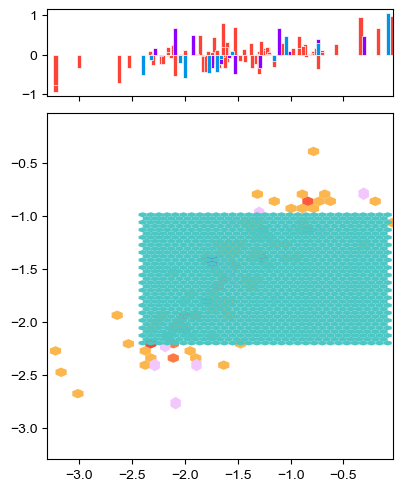

In [31]:
# Create a Figure, which doesn't have to be square.
fig = plt.figure(constrained_layout=True)
ax = fig.add_gridspec(top=0.5, right=0.75).subplots()
ax.set(aspect=1)
ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
# ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)
# ax_histy.tick_params(axis="y", labelleft=False)
x1 = y_train; y1 = y_pred_train_avg.flatten()
x2 = y_val; y2 = y_pred_val_avg.flatten()
x3 = y_test; y3 = y_pred_test_avg.flatten()
# scatter_hist(x1, y1, ax, ax_histx, 30, 'summer', 'green')
# scatter_hist(x2, y2, ax, ax_histx, 20, 'winter', 'blue')
# scatter_hist(x3, y3, ax, ax_histx, 30, 'Blues', 'orange')
scatter_hist(x1, y1, ax, ax_histx, 30, cmap3, (0.984, 0.262, 0.219))
scatter_hist(x2, y2, ax, ax_histx, 20, cmap2, (0.557, 0, 0.998))
scatter_hist(x3, y3, ax, ax_histx, 30, cmap1, (0, 0.576, 0.902))

# fig.colorbar(hb1)  ## some problem with color bars; take from manual plot above
# fig.colorbar(hb2)
# fig.colorbar(hb3)
# plt.show()
plt.xlim([-3.3,-0.03])
plt.ylim([-3.3,-0.03])
plt.savefig('hexbin_performance_ce_plsr_022324.eps', dpi=300)

In [11]:
max(y_train)
min(y_train)

-3.221848749725743

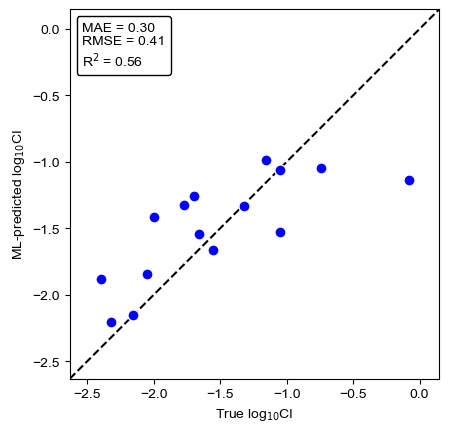

In [22]:
# plot_parity(y_train, y_pred_train_avg, figname=None)
# plot_parity(y_val, y_pred_val_avg.flatten(), figname=None)
plot_parity(y_test, y_pred_test_avg.flatten(), figname=None)

In [19]:
y_pred_train_avg
y_train

array([-2.        , -1.4436975 , -0.8569852 , -0.91865269, -2.        ,
       -1.85387196, -1.33724217, -0.57186521, -2.30103   , -1.69897   ,
       -1.7235382 , -2.        , -1.60205999, -2.        , -2.30103   ,
       -0.78515615, -1.49485002, -1.61978876, -3.22184875, -1.52287875,
       -0.86327943, -1.7212464 , -0.69897   , -1.43179828, -0.80134291,
       -2.04575749, -1.48148606, -1.24412514, -1.60205999, -2.03338901,
       -1.09691001, -1.56863624, -1.77989191, -1.21467017, -1.74472749,
       -0.17515853, -1.60205999, -2.15490196, -1.08092191, -0.88605665,
       -2.11350927, -0.33913452, -2.09691001, -0.69897   , -1.69897   ,
       -2.30103   , -2.        , -1.22184875, -1.82390874, -1.20065945,
       -1.7212464 , -1.69897   , -1.61439373, -2.12784373, -1.52287875,
       -1.30103   , -1.25963731, -1.67778071, -0.7619539 , -0.97469413,
       -2.15490196, -2.09691001, -1.88605665, -1.30103   , -2.04575749,
       -1.74472749, -0.95860731, -2.52287875, -1.69897   , -1.69